In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#data processing 
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [4]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
#set seed for reproducibility
seed=42

In [8]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

**Load the data**

In [9]:
df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

In [10]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [12]:
df.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [13]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/tmp/ipykernel_24/1259316306.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [14]:
# checking duplicate tweets
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


In [16]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [17]:
# tweet count by date
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

/tmp/ipykernel_24/2356267755.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')


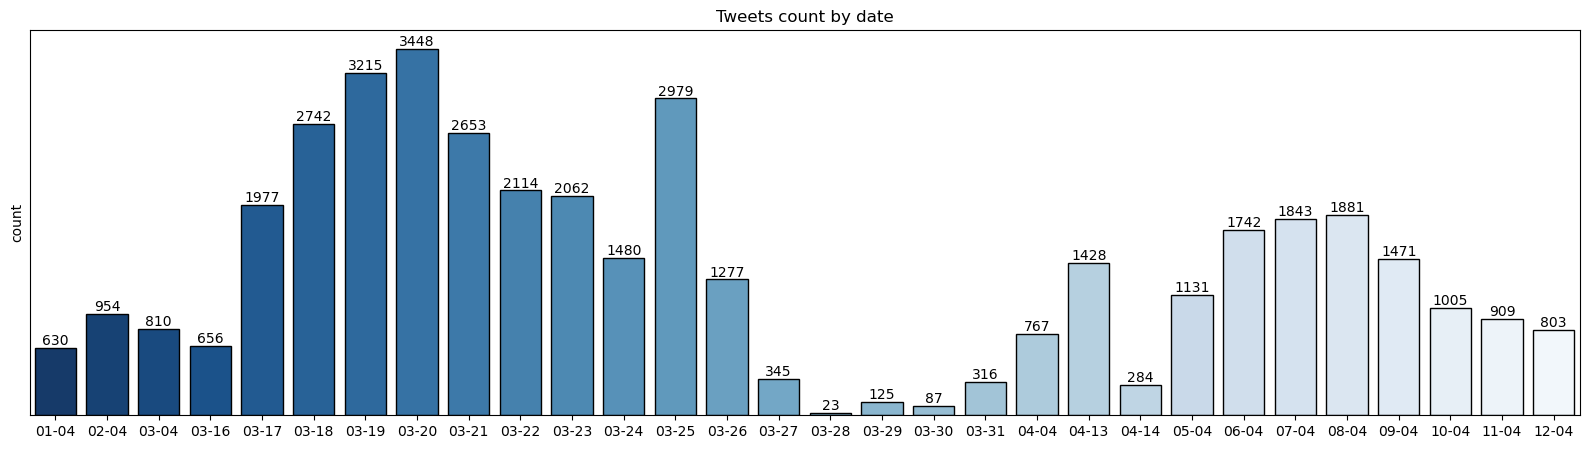

In [18]:

plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [19]:
# tweets per country and city
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

/tmp/ipykernel_24/3314811069.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')


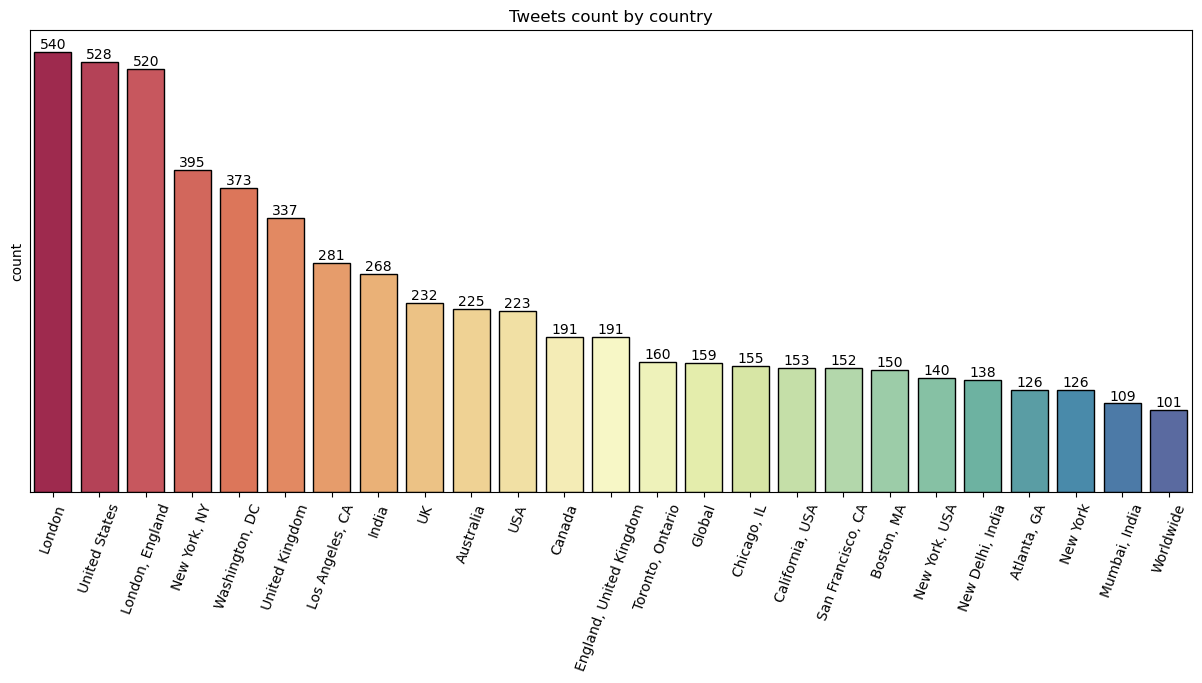

In [20]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

**Data Cleaning**

In [21]:
df = df[['OriginalTweet','Sentiment']]

In [22]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [23]:
# building custom functions to clean the data

def strip_emoji(text):
    #return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji
    emoji_pattern = re.compile(r"[^\w\s]|[\u2000-\u3000]")
    return emoji_pattern.sub("", text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [24]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [25]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [26]:
# now we can cerate new column, for both train and test sets
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [27]:
df['text_clean'].head()

0    menyrbie philgahan chrisitv httpstcoifz9fan2pa...
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [28]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [29]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak httpstcobinca9vp8p',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral httpstcozrlg0z520j',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement httpstcousmualq72n',
       'as news of the regions first confirmed c

In [30]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [31]:
df['text_len'] = text_len

In [32]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [33]:
df_test['text_len'] = text_len_test

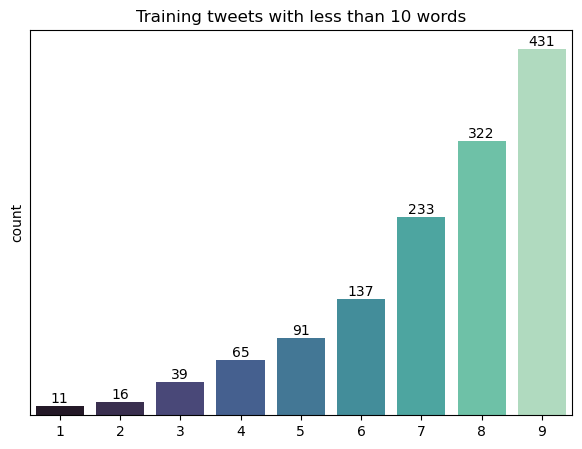

In [34]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

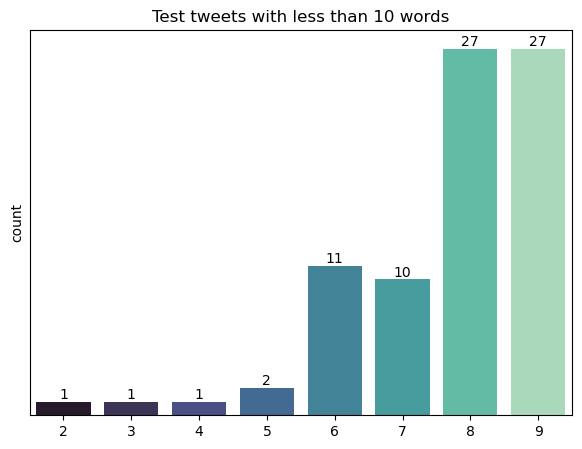

In [35]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [36]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [37]:
df = df[df['text_len'] > 4]

In [38]:
df_test = df_test[df_test['text_len'] > 4]

In [39]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41026, 4)
 DF TEST SHAPE: (3795, 4)


In [40]:
# using the bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [41]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [42]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 104


In [43]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 947, TEXT: a thought then to those of us with no income for 6yrs 1950s60 women 73 job seekersuchow to stock up food for week let alone months90000 our cohort dead in less yearsthen hit this mp youre disgrace borisjohnson onevoice ageconcern coronavirus mentalhealth dwpcrimes httpstco2coihjl8ic httpstco7wev8xeps0
INDEX: 1212, TEXT: we are offering you free delivery this week so you dont have to leave the house tampcs apply freedelivery avoidcrowds coronavirus covid19 southafrica coffee stockup besafe washyourhands keepcalm drinkcoffee cleanyourmachine descale httpstcoushgdvksv3 httpstcoj68ze0gz3p
INDEX: 1632, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s policiecz podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 1691, TEXT: i work at a grocery store we wont get any toilet paper for the next 2 week hope yall like wiping your as

In [44]:
df['token_lens'] = token_lens

In [45]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,40,104
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,37,103
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,40,96
7483,#Oil futures in NY jumped 11% to $22.54/barrel...,Positive,oil futures in ny jumped 11 to 2254barrel more...,32,95
36545,Global Tenders / RFP For Disinfectant &amp; Sa...,Positive,global tenders rfp for disinfectant amp saniti...,27,95
9027,La escena se repite alrededor del mundo: desde...,Neutral,la escena se repite alrededor del mundo desde ...,41,94
953,A thought then to those of us with NO INCOME f...,Extremely Negative,a thought then to those of us with no income f...,45,93
39588,Trending Australian news stories for 13 Apr. 2...,Neutral,trending australian news stories for 13 apr 20...,29,93
35563,@JaganNKaushik @sn_ojha @Surindernath1 @URRao1...,Neutral,jagannkaushik snojha surindernath1 urrao10 ver...,20,92


In [46]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
30473,@MattFingersArni @brianbloop2 @Roblev0 @Cheese...,Neutral,mattfingersarni brianbloop2 roblev0 cheesenbra...,18,91
39587,Trending Australian news stories (12:00 to 18:...,Neutral,trending australian news stories 1200 to 1800 ...,29,91
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,40,90
32809,Did you know that @barbicideblue is a hospital...,Extremely Positive,did you know that barbicideblue is a hospital ...,44,90
38817,Artnaturals Alcohol Based Hand Sanitizer Gel (...,Extremely Positive,artnaturals alcohol based hand sanitizer gel 1...,36,89


In [47]:
df = df.sample(frac=1).reset_index(drop=True)

In [48]:
# test data cleaning
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [49]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 102


In [50]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 236, TEXT: so according to this dude if you eat rama margarine leaver spread koo beans coronavirus checks into your system amp if it doesnt like the food you eat the virus checks out amp may host itself into someone that eats like ciabatta so stock up on koo beans coronavirusinsa httpstcojqsmbxpxs7 httpstco7z8ff2jhy5
INDEX: 286, TEXT: rhett800cc so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 313, TEXT: stock up on food amp water asap before the forced quarantines for the deadly coronavirus httpstcowogxp8sooe covid19 covid19 stocks bonds silver gold slv gld intern nurse rn medstudent paramedic trucker patriot taxi prepper veteran hunter biker surfer bartender e3 eos bch xrp httpstcohrh9n4vicv
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobo

In [51]:
df_test['token_lens'] = token_lens_test

In [52]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,45,102
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,rhett800cc so hard to decide as much as i want...,39,101
3066,@Janetb172 @denyessence @NoScienceDenial @west...,Neutral,janetb172 denyessence nosciencedenial westworl...,19,91
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,45,88
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
236,"So, according to this dude if you eat Rama mar...",Extremely Positive,so according to this dude if you eat rama marg...,51,85
3068,"Apart from these irresponsible shoppers, the c...",Extremely Negative,apart from these irresponsible shoppers the cr...,43,83
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,44,83
313,Stock up on Food &amp; Water asap before the f...,Negative,stock up on food amp water asap before the for...,43,83
3195,@KrampusFu @JackHer18731941 @Twistagirl1958 @W...,Neutral,krampusfu jackher18731941 twistagirl1958 willy...,18,82


In [53]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
236,"So, according to this dude if you eat Rama mar...",Extremely Positive,so according to this dude if you eat rama marg...,51,85
3068,"Apart from these irresponsible shoppers, the c...",Extremely Negative,apart from these irresponsible shoppers the cr...,43,83
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,44,83


In [54]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

**Sentiment column analysis**

In [55]:
# we look at the target column
df['Sentiment'].value_counts()

Positive              11395
Negative               9902
Neutral                7620
Extremely Positive     6620
Extremely Negative     5477
Name: Sentiment, dtype: int64

In [56]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [57]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [58]:
df['Sentiment'].value_counts()

2    18015
0    15379
1     7620
Name: Sentiment, dtype: int64

**Class Balance by RandomOverSampler**

In [59]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [60]:
train_os['Sentiment'].value_counts()

0    18015
1    18015
2    18015
Name: Sentiment, dtype: int64

**Train test split**

In [61]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [63]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

**one hot encoding**

In [64]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [65]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [66]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48640
VALIDATION DATA: 5405
TESTING DATA: 3790


**Naive Bayes Classifier**

In [67]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [68]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [69]:
nb_clf = MultinomialNB()

In [70]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [71]:
nb_pred = nb_clf.predict(X_test_tf)

In [72]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.69      0.81      0.75      1630
     Neutral       0.67      0.34      0.45       616
    Positive       0.72      0.73      0.73      1544

    accuracy                           0.70      3790
   macro avg       0.69      0.63      0.64      3790
weighted avg       0.70      0.70      0.69      3790



**BERT sentiment analysis**

In [73]:
MAX_LEN=128

In [74]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [75]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [76]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [77]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    #opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    #opt = tf.keras.optimizers.Adam(learning_rate=1e-5, learning_rate_schedule=tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=10000))
    #opt = tf.keras.optimizers.Adam(learning_rate=1e-5, learning_rate_schedule=tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=10000, decay_rate=0.96))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [78]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [79]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
1520/1520 [==============================] - 759s 472ms/step - loss: 0.5669 - categorical_accuracy: 0.7679 - val_loss: 0.3614 - val_categorical_accuracy: 0.8720
Epoch 2/4
1520/1520 [==============================] - 722s 475ms/step - loss: 0.2907 - categorical_accuracy: 0.8995 - val_loss: 0.2594 - val_categorical_accuracy: 0.9058
Epoch 3/4
1520/1520 [==============================] - 721s 474ms/step - loss: 0.1945 - categorical_accuracy: 0.9336 - val_loss: 0.2709 - val_categorical_accuracy: 0.9043
Epoch 4/4
1520/1520 [==============================] - 721s 474ms/step - loss: 0.1333 - categorical_accuracy: 0.9556 - val_loss: 0.2247 - val_categorical_accuracy: 0.9319


**BERT result**

In [80]:
result_bert = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 23s 166ms/step


In [81]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

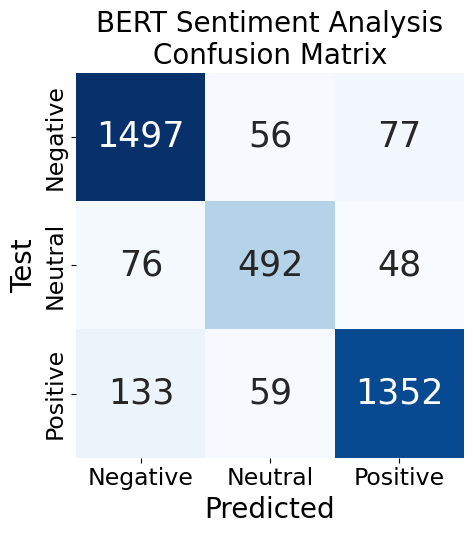

In [82]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [83]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.88      0.92      0.90      1630
     Neutral       0.81      0.80      0.80       616
    Positive       0.92      0.88      0.90      1544

   micro avg       0.88      0.88      0.88      3790
   macro avg       0.87      0.86      0.87      3790
weighted avg       0.88      0.88      0.88      3790
 samples avg       0.88      0.88      0.88      3790



**RoBERTa Sentement Analysis**

In [84]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [85]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

98

In [86]:
MAX_LEN=128

In [87]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [88]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

**RoBERTa modeling**

In [89]:
def create_model(bert_model, max_len=MAX_LEN):
    
    #opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    #opt = tf.keras.optimizers.Adam(learning_rate=1e-5, learning_rate_schedule=tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=10000))
    #opt = tf.keras.optimizers.Adam(learning_rate=1e-5, learning_rate_schedule=tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=10000, decay_rate=0.96))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [90]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [91]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [92]:
# RoBERTa result
result_roberta = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 24s 165ms/step


In [93]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

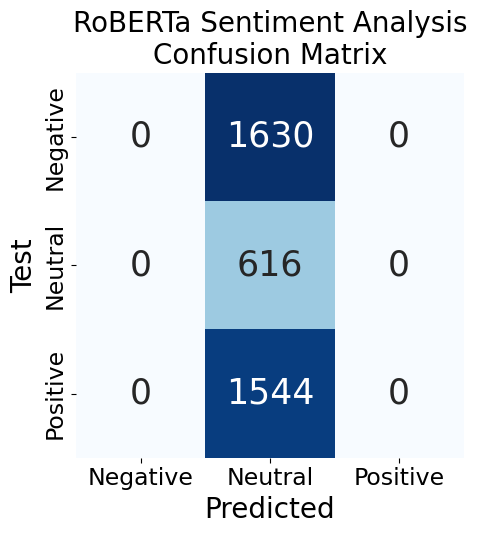

In [94]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [95]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1630
     Neutral       0.16      1.00      0.28       616
    Positive       0.00      0.00      0.00      1544

   micro avg       0.16      0.16      0.16      3790
   macro avg       0.05      0.33      0.09      3790
weighted avg       0.03      0.16      0.05      3790
 samples avg       0.16      0.16      0.16      3790



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Summery**

**BERT classification report**

In [96]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.88      0.92      0.90      1630
     Neutral       0.81      0.80      0.80       616
    Positive       0.92      0.88      0.90      1544

   micro avg       0.88      0.88      0.88      3790
   macro avg       0.87      0.86      0.87      3790
weighted avg       0.88      0.88      0.88      3790
 samples avg       0.88      0.88      0.88      3790



**RoBARTa classification result**

In [97]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for RoBERTa:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1630
     Neutral       0.16      1.00      0.28       616
    Positive       0.00      0.00      0.00      1544

   micro avg       0.16      0.16      0.16      3790
   macro avg       0.05      0.33      0.09      3790
weighted avg       0.03      0.16      0.05      3790
 samples avg       0.16      0.16      0.16      3790



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


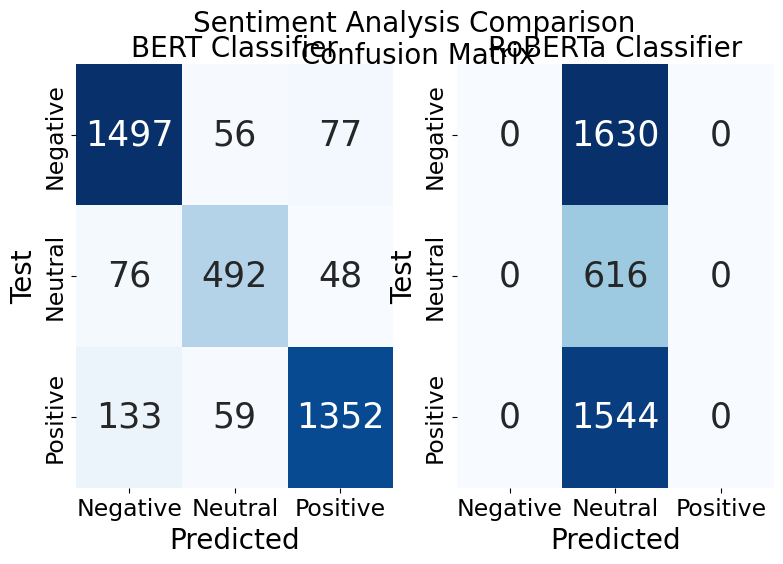

In [98]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)
plt.show()